In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import alphashape
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon

from sklearn.cluster import Birch
import itertools
from matplotlib import patches
from matplotlib.path import Path

from scipy.spatial import Voronoi

In [2]:
sns.set_style("darkgrid")

In [3]:
def anchors_to_contour(points, delta=0.4):
    x_plus_arr = points.copy()
    x_plus_arr[:, 0] = points[:, 0] + delta
    x_minus_arr = points.copy()
    x_minus_arr[:, 0] = points[:, 0] - delta
    y_plus_arr = points.copy()
    y_plus_arr[:, 1] = points[:, 1] + delta
    y_minus_arr = points.copy()
    y_minus_arr[:, 1] = points[:, 1] - delta

    points_discs = np.concatenate([x_plus_arr, x_minus_arr, y_plus_arr, y_minus_arr])
    return points_discs

def smooth_poly_Douglas_Peucker(poly, douglas_peucker_tolerance):
    _poly = Polygon(poly)
    _poly = _poly.simplify(douglas_peucker_tolerance, preserve_topology=True)
    x, y = _poly.exterior.coords.xy
    return list(zip(x, y))

def smooth_poly_Chaikins_corner_cutting_iter(poly, iter=1):
    new_poly = poly[:]
    for i in range(iter):
        new_poly = smooth_poly_Chaikins_corner_cutting(new_poly, True)
    return new_poly

def smooth_poly_Chaikins_corner_cutting(poly, append_first_point):
    """
    poly is list of lists
    example: poly1 = [
    [3,3],
    [4,4],
    [5,4],
    [5,7],
    [6,8],
    [7,5],
    [6,3],
    [5,2],
    [4,2],
    [3,3]
    ]
    Based on https://stackoverflow.com/questions/27642237/smoothing-a-2-d-figure
    Q(i) = (3/4)P(i) + (1/4)P(i+1)
    R(i) = (1/4)P(i) + (3/4)P(i+1)
    """
    new_poly = []
    for i in range(len(poly) - 1):
        q_i = [0.75 * poly[i][0] + 0.25 * poly[i + 1][0], 0.75 * poly[i][1] + 0.25 * poly[i + 1][1]]
        r_i = [0.25 * poly[i][0] + 0.75 * poly[i + 1][0], 0.25 * poly[i][1] + 0.75 * poly[i + 1][1]]
        new_poly.extend([q_i, r_i])
    # append first point for smoothness
    if append_first_point:
        new_poly.append(new_poly[0])
    return new_poly

def get_concave_hull(points, alpha, spline=False, vis=False, douglas_peucker_tolerance=0.6, smooth_iter=13):
    alpha_shape = alphashape.alphashape(points.tolist(), alpha)
    smooth_shapes = []
    if isinstance(alpha_shape, shapely.geometry.polygon.Polygon):
        alpha_shape = [alpha_shape]
    else:  # Multipolygon
        alpha_shape = list(alpha_shape)
    for shape in list(alpha_shape):
        x, y = shape.exterior.coords.xy
        if not spline:
            if vis:
                smooth_shape = np.array(smooth_poly_Chaikins_corner_cutting_iter(
                                    smooth_poly_Douglas_Peucker(list(zip(x, y)), douglas_peucker_tolerance),
                    iter=smooth_iter))
            else:
                smooth_shape = np.array(list(zip(x, y)))
        else:
            tck, u = splprep([np.array(x), np.array(y)], s=3)
            new_points = splev(u, tck)
            x, y = new_points[0], new_points[1]
            smooth_shape = np.array(list(zip(x,y)))
        smooth_shapes.append(smooth_shape)
    return smooth_shapes

In [4]:
def points_anchors_patches_plot(df, df_centroids, concave_hulls, 
                                show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True):
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot points
    if show_points:
        sns.scatterplot(data=df, x='x', y='y',
                        ax=ax, color='green', s=50, linewidth=1, edgecolor='black')
    # Plot anchors
    if show_anchors:
        sns.scatterplot(data=df_centroids, x='x', y='y',
                        ax=ax, color='red', s=250, linewidth=1, edgecolor='black')

    # Add patches
    if show_polygons:
        palette = itertools.cycle(sns.color_palette())
        c = next(palette)
        for concave_hull in concave_hulls:
            # Skip polygons with very small area that will appear as dots
            if Polygon(concave_hull).area < 0.001:
                self.print_verbose(f'Skipping polygon of label {label} with area {Polygon(concave_hull).area}')
                continue
            coords = concave_hull
            line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(coords) - 2) + [Path.CLOSEPOLY]
            path = Path(coords, line_cmde)
            patch = patches.PathPatch(path, facecolor=c, alpha=0.2, linewidth=None, edgecolor=None)
            ax.add_patch(patch)
            patch = patches.PathPatch(path, facecolor=None, linewidth=10, edgecolor=c, fill=False)
            ax.add_patch(patch)

        if show_inner_blobs:
            points = df_centroids[['x', 'y']].values
            vor = Voronoi(points)

            regions, vertices = voronoi_finite_polygons_2d(vor)

            mask = Polygon(concave_hulls[0])
            for region in regions:
                polygon = vertices[region]
                shape = list(polygon.shape)
                shape[0] += 1
                p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
                # intersection can create MultiPolygon
                if isinstance(p, shapely.geometry.polygon.Polygon):
                    polygons = [p]
                else:  # Multipolygon
                    polygons = list(p)

                for p in list(polygons):
                    # skip anchors outside the polygon due to simplification
                    if p.exterior is None:
                        continue
                    x, y = p.exterior.coords.xy
                    inner_blob = list(zip(x,y))
                    #plot patch
                    line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(inner_blob) - 2) + [Path.CLOSEPOLY]
                    path = Path(inner_blob, line_cmde)
                    patch = patches.PathPatch(path, facecolor=None, linewidth=5, edgecolor=c, fill=False)
                    ax.add_patch(patch)
        
    # remove ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    # remove labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.show()

In [5]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [6]:
xy = np.array([
    [1,6],
    [1.5,6.5],
    [1.5,7],
    [2,5.5],
    [2,7],
    [2.5,7.5],
    [2.6,8.1],
    [3,8],
    [3.5,7.7],
    [4,8],
    [4,5.6],
    [4.5,4],
    [5,3],
    [5,10],
    [5.7,9],
    [6,8],
    [7,6],
    [7,9],
    [7.4,5],
    [7.5,3.9],
    [8,4.6],
    [8,5.2],
    [8.1,6.9],
    [8.9,5.9],
    [9,1.8],
    [9,4.9],
    [9.5,1],
    [9.6,1.6],
    [10.1,1],
    [10,1.4],
    [10.5,0.5],
    [10.52,1.55],
    [10.54,2],
    [11,3.9],
    [10.5,6.5],
    [11,6],
    [11,7],
    [11,8],
    [12.2,7.3],
    [13,6],
    [12,1.1],
    [12.1,1.9],
    [12.5,1.2],
    [13,1.3],
    [13.1,1.5],
])

In [7]:
df = pd.DataFrame(xy, columns = ['x', 'y'])

In [8]:
points_discs = anchors_to_contour(np.array(xy))

In [9]:
concave_hulls = get_concave_hull(points_discs, alpha=0.6, spline=False, vis=True, douglas_peucker_tolerance=0, smooth_iter=5)

In [10]:
birch = Birch(threshold=2, branching_factor=2, n_clusters=None)
df['sub-cluster'] = birch.fit_predict(df.values)

In [15]:
df_centroids = pd.DataFrame(birch.subcluster_centers_, columns=['x', 'y'])
df_centroids

,x,y
0,2.853846,6.453846
1,6.350000,7.833333
2,8.500000,4.275000
3,11.385714,6.385714
4,11.269091,1.368182


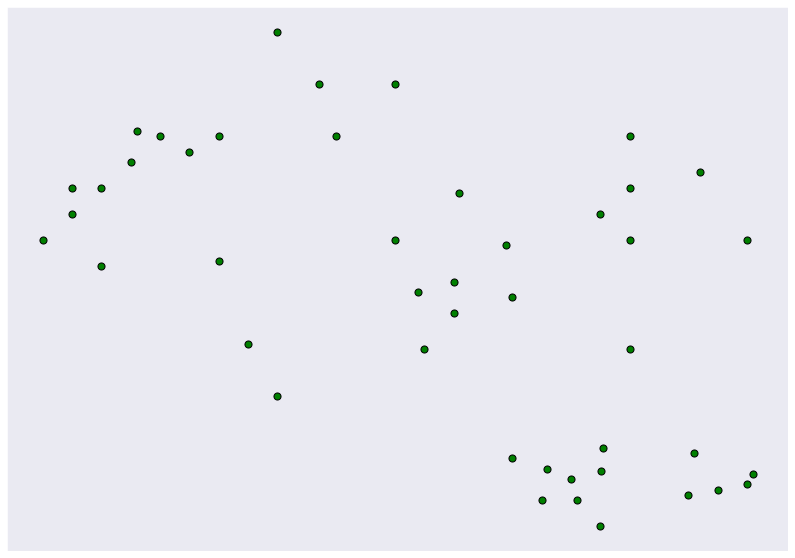

In [16]:
points_anchors_patches_plot(df, df_centroids, concave_hulls,
                            show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True)

IndexError: list index out of range

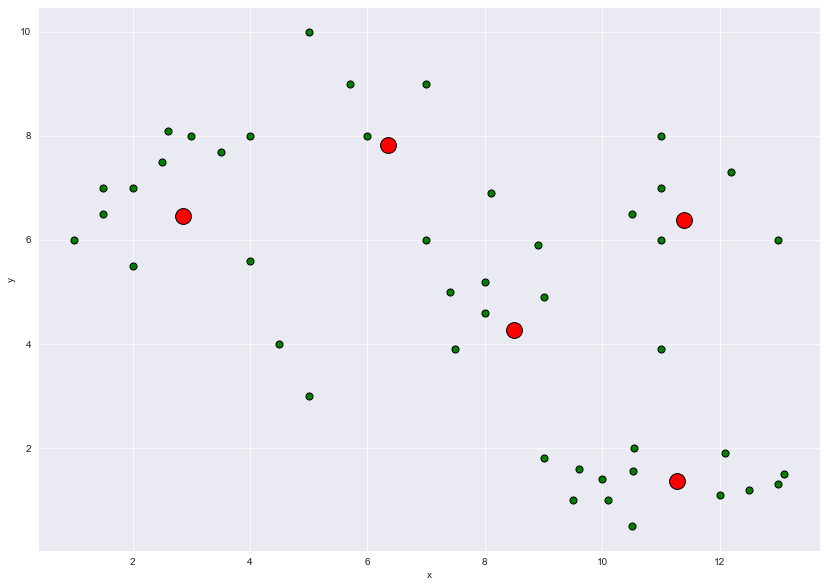

In [13]:
points_anchors_patches_plot(df, df_centroids, concave_hulls,
                            show_inner_blobs=True, show_points=True, show_anchors=True, show_polygons=True)